In [ ]:
import benchmax.inspection as ev
import pandas as pd
import tikzplotlib

stats    = ev.csv_to_pandas("stats_qe_25-04-11_09:58.csv")

stats    = ev.csv_to_pandas("stats_qe_25-04-11_09:58.csv",exclude=["smtrat-coverings-EvalSettings"])
stats    = stats.join(ev.csv_to_pandas("stats_qe_25-04-24_10:17_smtrat-coverings-EvalSettings.csv"))
stats    = stats.join(ev.csv_to_pandas("stats_qe_25-04-24_16:28_smtrat-coverings-EvalPBcldboundsSettings.csv"))
stats    = stats.join(ev.csv_to_pandas("stats_qe_25-04-24_16:28_smtrat-nucad-EvalPBcldboundsSettings.csv"))


stats = ev.rename_solvers(stats, {
 'smtrat-coverings-EvalSettings': "CAlC",
 'smtrat-nucad-EvalSettings': "NuCAD",
 'smtrat-coverings-EvalPBcldboundsSettings': "CAlC<BcLdBounds,BcLdBoundsCov>",
 'smtrat-nucad-EvalPBcldboundsSettings': "NuCAD<BcLdBounds>"
 })

def compute_poly_count(df, s):
    df[(s,'smtrat-cadcells_projections.poly_count')] = df[(s,'smtrat-cadcells_projections.coefficient.level.count')] + df[(s,'smtrat-cadcells_projections.discriminant.level.count')] + df[(s,'smtrat-cadcells_projections.factor.level.count')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.level.count')] + df[(s,'smtrat-cadcells_projections.resultant.level.count')]
    df[(s,'smtrat-cadcells_projections.discres.poly_count')] = df[(s,'smtrat-cadcells_projections.discriminant.level.count')] + df[(s,'smtrat-cadcells_projections.resultant.level.count')]

def compute_poly_total_degree(df, s):
    df[(s,'smtrat-cadcells_projections.poly.total_degree.sum')] = df[(s,'smtrat-cadcells_projections.coefficient.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.discriminant.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.factor.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.sum')] + df[(s,'smtrat-cadcells_projections.resultant.total_degree.sum')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.count')] = df[(s,'smtrat-cadcells_projections.coefficient.total_degree.count')] + df[(s,'smtrat-cadcells_projections.discriminant.total_degree.count')] + df[(s,'smtrat-cadcells_projections.factor.total_degree.count')] + df[(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.count')] + df[(s,'smtrat-cadcells_projections.resultant.total_degree.count')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.avg')] = df[(s,'smtrat-cadcells_projections.poly.total_degree.sum')] / df[(s,'smtrat-cadcells_projections.poly.total_degree.count')]
    df[(s,'smtrat-cadcells_projections.poly.total_degree.max')] = df[[(s,'smtrat-cadcells_projections.coefficient.total_degree.max'),(s,'smtrat-cadcells_projections.discriminant.total_degree.max'),(s,'smtrat-cadcells_projections.factor.total_degree.max'),(s,'smtrat-cadcells_projections.leading_coefficient.total_degree.max'),(s,'smtrat-cadcells_projections.resultant.total_degree.max')]].max(axis=1)

def compute_interval_count(df, s):
    df[(s,'smtrat-cadcells_heuristics.interval.point_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.point_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]
    df[(s,'smtrat-cadcells_heuristics.interval.closed_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.closed_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]
    df[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.halfclosed_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]
    df[(s,'smtrat-cadcells_heuristics.interval.open_count.rel')] = df[(s,'smtrat-cadcells_heuristics.interval.open_count.by_depth.total')] / df[(s,'smtrat-cadcells_heuristics.interval.count.by_depth.total')]

def compute_timer(df, s):
    def sum_timer(df,s,result,timers):
        df[(s,result+'.overall_ms')] = sum([df[(s,t+'.overall_ms')] for t in timers])
        df[(s,result+'.overall_µs')] = sum([df[(s,t+'.overall_µs')] for t in timers])
        df[(s,result+'.count')] = sum([df[(s,t+'.count')] for t in timers])
        df[(s,result+'.active_at_timeout')] = sum([df[(s,t+'.active_at_timeout')] for t in timers])

    sum_timer(df, s, 'smtrat-cadcells_projections.timer.real_root_isolation', ['smtrat-cadcells_projections.timer.real_roots','smtrat-cadcells_projections.timer.is_nullified', 'smtrat-cadcells_projections.timer.num_roots'])

for s in ev.get_solvers(stats):
    compute_poly_count(stats, s)
    compute_poly_total_degree(stats, s)
    compute_interval_count(stats, s)
    compute_timer(stats, s)
    stats = stats.copy()

def sanitize(df):
    for solver in ev.get_solvers(df):
        df.loc[(df[(solver,'peak_memory_kbytes')]>3900000) & (df[(solver,'answer')]=='segfault'),(solver,'answer')] = 'memout'
        df.loc[(df[(solver,'answer')].isna()),(solver,'answer')] = 'timeout'

stats    = stats.join(ev.csv_to_pandas("stats_qe_25-02-25_14:19.csv", rename={'tarski_wrapper.py': 'QEPCAD B', 'redlog_wrapper.py': 'Redlog'}))
for s in ev.get_solvers(stats):
    if "output_amount_atoms" in ev.get_fields(stats,s):
        stats[(s,'qe_output_amount_atoms')] = stats[(s,'output_amount_atoms')] 

sanitize(stats)

ev.transform_to_seconds(stats)
ev.setup_accessible_styles()

solvers = list(ev.get_solvers(stats))

In [16]:
ev.inspect_answer(stats)

NuCAD  CAlC  CAlC<BcLdBounds,BcLdBoundsCov>  NuCAD<BcLdBounds>  \
count       78    78                              78                 78   
sat         52    50                              51                 54   
unsat        6     6                               6                  6   
unknown      0     0                               0                  0   
timeout     20    22                              21                 18   
solved      58    56                              57                 60   

         QEPCAD B  Redlog  
count          78      78  
sat            38      51  
unsat           6       6  
unknown        27       0  
timeout         7      21  
solved         44      57

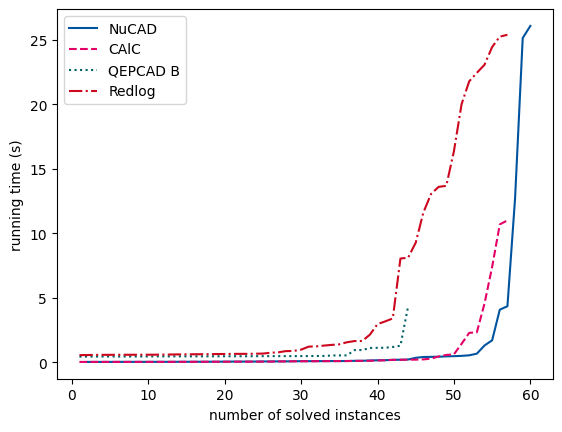

In [20]:
plot = ev.performance_profile(stats,['NuCAD<BcLdBounds>','CAlC<BcLdBounds,BcLdBoundsCov>','QEPCAD B','Redlog'])
plot.axes.legend(['NuCAD','CAlC','QEPCAD B','Redlog'])
plot.set_ylabel('running time (s)')
tikzplotlib.save('results_qe.tex',axis_width='5cm',axis_height='7cm')